## Testing a new approach 
- What if the update rule was not about whether <font size =4>$C'* > C*$</font> or not but whether the value of<font color='orange' size=5> $\frac{C'*}{\theta'*} > \frac{C*}{\theta*}$.</font>
- This rule incorporates the view that if the **cost is high and the theta is minimum**, that basis vector goes ahead as the best basis vector in our algorithm
- We may also use $cos(x),\ cos^{2}(x),\ e^{-x},\ e^{-x^{2}} and \frac{1}{x^{2}}$ instead of just $\frac{1}{x}$ to again capture the same thing that we are trying to achieve
- Let us test this with resolution = 30, max_iters = 15. 
- A thing to note is that the **precision** metric is not relevant now as our cost function has now changed.
- We now need to have a new metric which is may not be confined to $[0,1]$ when the cost function has the $\frac{1}{x^{2}}$ or the $\frac{1}{x}$ factor

In [3]:
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.extensions import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import assemble
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from time import sleep
import sys
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

## Probable cost functions
- Any decreasing and monotonic function in the interval [0,1] shall work
- Currently trying for $cos(\x),\ cos^{2}(\x),\ e^{-x},\ e^{-x^{2}} and \frac{1}{x^{2}}$ are used

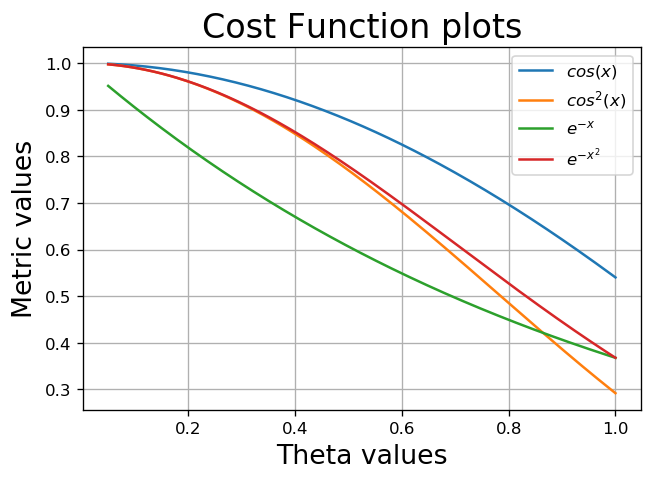

In [23]:
x = np.linspace(0.05, 1, 200)
c = np.cos(x)
c2 = (np.cos(x))**2
ex = np.exp(-x)
ex2 = np.exp(-x**2)
x_inv = (1/x)
plt.figure(dpi=120)
plt.title("Cost Function plots", fontsize=20)
plt.xlabel("Theta values", fontsize=16)
plt.ylabel("Metric values", fontsize=16)
plt.plot(x, c, label="$cos(x)$")
plt.plot(x, c2, label="$cos^{2}(x)$")
plt.plot(x, ex, label="$e^{-x}$")
plt.plot(x, ex2, label="$e^{-x^{2}}$")
plt.grid()
plt.legend()

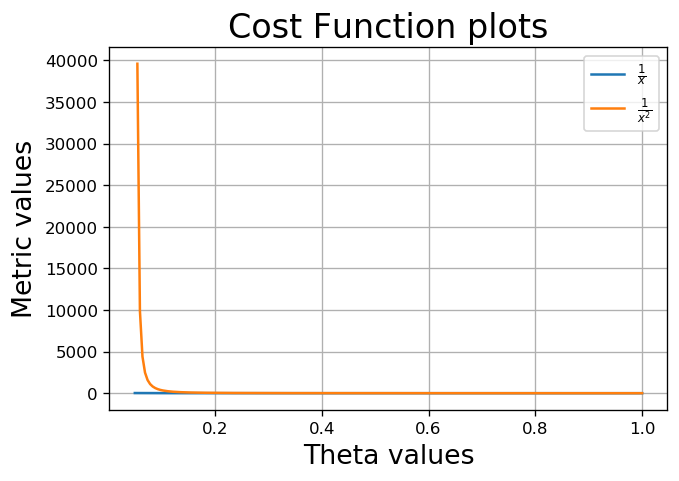

In [22]:
plt.figure(dpi=120)
plt.title("Cost Function plots", fontsize=20)
plt.xlabel("Theta values", fontsize=16)
plt.ylabel("Metric values", fontsize=16)
plt.plot(x, x_inv, label="$\\frac{1}{x}$")
plt.plot(x, x_inv2, label="$\\frac{1}{x^{2}}$")
plt.grid()
plt.legend()

## Modified class with changed cost function

In [37]:
class global_max_SPEA():
    def __init__(self, unitary, cost_function, max_metric_val, resolution=100, max_iters=20):

        # handle resolution
        if not isinstance(resolution, int):
            raise TypeError(
                "Please enter the number of intervals as an integer value")
        if resolution < 10 or resolution > 1e6:
            raise ValueError(
                "Resolution needs to be atleast 0.1 and greater than 0.000001")

        self.resolution = resolution

        # handle unitary
        if not isinstance(unitary, np.ndarray) and not isinstance(unitary, QuantumCircuit)\
                and not isinstance(unitary, UnitaryGate):
            raise TypeError(
                "A numpy array or Quantum Circuit or UnitaryGate needs to be passed as the unitary matrix")

        # convert circuit to numpy array for uniformity
        if isinstance(unitary, UnitaryGate):
            U = unitary.to_matrix()
        else:  # both QC and ndarray type
            U = unitary

        # note - the unitary here is not just a single qubit unitary
        if isinstance(U, np.ndarray):
            self.dims = U.shape[0]
        else:
            self.dims = 2**(U.num_qubits)

        if isinstance(U, np.ndarray):
            self.c_unitary_gate = UnitaryGate(data=U).control(
                num_ctrl_qubits=1, label='CU', ctrl_state='1')
        else:
            self.c_unitary_gate = U.control(
                num_ctrl_qubits=1, label='CU', ctrl_state='1')

        # handle metric
        if not isinstance(max_metric_val, int) and not isinstance(max_metric_val, float):
            raise TypeError(
                "The required metric value should be provided as an int or a float.")
        elif max_metric_val <= 0:
            raise ValueError(
                "The required metric must be finite and greater than 0.")
        elif cost_function in ['cos', 'cos2', 'exp', 'exp2'] and max_metric_val > 1:
            raise ValueError(
                "Maximum metric can't be greater than 1 in case of given cost function")

        self.max_metric = max_metric_val

        # handle max_iters
        if not isinstance(max_iters, int):
            raise TypeError("Max iterations must be of integer type")
        if max_iters <= 0 and max_iters > 1e5:
            raise ValueError(
                "Max iterations should be atleast 1 and less than 1e5")

        self.iterations = max_iters
        cost_fns = ['cos', 'cos2', 'exp', 'exp2', 'inv', 'inv2']
        # handle cost function
        if cost_function not in cost_fns:
            raise ValueError(
                "Cost function must be one of [cos, cos2, exp, exp2, inv, inv2]")

        self.cost_function = cost_function
        self.basis = []

    def __get_basis_vectors(self, randomize=True):
        # get the d dimensional basis for the unitary provided
        if randomize == True:
            UR = unitary_group.rvs(self.dims)
        else:
            UR = np.identity(self.dims)

        basis = []
        for k in UR:
            basis.append(np.array(k, dtype=complex))
        return basis

    def __get_unitary_circuit(self, backend):
        '''Return the pretranspiled circuit '''
        if backend is None:
            backend = Aer.get_backend('qasm_simulator')

        qc = QuantumCircuit(1 + int(np.log2(self.dims)))

        # make the circuit
        qc.h(0)
        qc = qc.compose(self.c_unitary_gate, qubits=range(
            1+int(np.log2(self.dims))))

        qc.barrier()
        qc = transpile(qc, backend=backend, optimization_level=3)

        return qc

    def __get_circuit(self, state, backend, shots, angle=None):
        '''Given an initial state ,
          return the circuit that is generated with 
          inverse rotation '''
        # all theta values are iterated over for the same state
        phi = Initialize(state)

        qc1 = QuantumCircuit(1 + int(np.log2(self.dims)), 1)
        # initialize the circuit
        qc1 = qc1.compose(phi, qubits=list(
            range(1, int(np.log2(self.dims))+1)))
        qc1.barrier()
        qc1 = transpile(qc1, backend=backend, optimization_level=1)

        # get the circuit2
        qc2 = self.unitary_circuit

        qc3 = QuantumCircuit(1 + int(np.log2(self.dims)), 1)
        if angle is not None:
            # add inverse rotation on the first qubit
            qc3.p(-2*np.pi*angle, 0)
        # add hadamard
        qc3.h(0)
        qc3 = transpile(qc3, backend=backend, optimization_level=1)

        # make final circuit
        qc = qc1 + qc2 + qc3

        # measure
        qc.measure([0], [0])

#         qc = assemble(qc,shots = shots)
        return qc

    def __get_standard_cost(self, angles, state, backend, shots):
        '''Given an initial state and a set of angles,
          return the best cost and the associated angle
          state is a normalized state in ndarray form'''
        result = {'cost': -1, 'theta': -1}
        # all theta values are iterated over for the same state
        circuits = []

        for theta in angles:
            qc = self.__get_circuit(state, backend, shots, theta)
            circuits.append(qc)

        # execute only once...
        counts = backend.run(circuits, shots=shots).result().get_counts()
        # get the cost for this theta
        for k, theta in zip(counts, angles):
            # for all experiments you ran
            try:
                C_val = (k['0'])/shots
            except:
                C_val = 0

            if C_val > result['cost']:
                # means this is a better theta value
                result['theta'] = theta
                result['cost'] = C_val
        return result

    def __get_alternate_cost(self, angles, state, backend, shots):
        '''Given an initial state and a set of angles,
          return the best cost and the associated angle
          state is a normalized state in ndarray form'''
        result = {'cost': -1, 'theta': -1}
        # all theta values are iterated over for the same state
        # run the circuit once
        qc = self.__get_circuit(state, backend, shots)

        # execute only once...
        counts = backend.run(qc, shots=shots).result().get_counts()

        # generate experimental probabilities
        try:
            p0 = counts['0']/shots
        except:
            p0 = 0
        try:
            p1 = counts['1']/shots
        except:
            p1 = 0

        # now, find the best theta as specified by the
        # alternate method classically
        min_s = 1e5
        for theta in angles:
            # generate theoretical probabilities
            c0 = (np.cos(np.pi*theta))**2
            c1 = (np.sin(np.pi*theta))**2

            # generate s value
            s = (p0-c0)**2 + (p1-c1)**2
            if s < min_s:
                result['theta'] = theta
                min_s = s

        # now , we have the best theta stored in phi
        # run circuit once again to get the value of C*
        qc = self.__get_circuit(state, backend, shots, result['theta'])
        counts = backend.run(qc, shots=shots).result().get_counts()

        try:
            result['cost'] = counts['0']/shots
        except:
            result['cost'] = 0
        # no 0 counts present

        # return the result
        return result

    def __get_metric_val(self, cost, theta):
        '''Generate optimization metric value 
        based on the given cost function '''
        func = self.cost_function

        if func == 'cos':
            return cost*(np.cos(theta))
        elif func == 'cos2':
            return cost*((np.cos(theta))**2)
        elif func == 'exp':
            return cost*(np.exp(-theta))
        elif func == 'exp2':
            return cost*(np.exp(-theta**2))
        elif func == 'inv':
            try:
                return cost/theta
            except:
                return 1e7
        elif func == 'inv2':
            try:
                return cost/(theta**2)
            except:
                return 1e7

    def get_eigen_pair(self, backend, algo='alternate', theta_left=0, theta_right=1,
                       progress=False, basis=None, basis_ind=None, randomize=True, target_metric=None, shots=512
                       ):
        '''Finding the eigenstate pair for the unitary'''
        # handle algorithm...

        self.unitary_circuit = self.__get_unitary_circuit(backend)

        # handle theta bounds
        if(theta_left > theta_right):
            raise ValueError(
                "Left bound for theta should be smaller than the right bound")
        elif (theta_left < 0) or (theta_right > 1):
            raise ValueError("Bounds of theta are [0,1].")

        # handle algorithm
        if not isinstance(algo, str):
            raise TypeError(
                "Algorithm must be mentioned as a string from the values {alternate,standard}")
        elif algo not in ['alternate', 'standard']:
            raise ValueError(
                "Algorithm must be specified as 'alternate' or 'standard' ")

        if target_metric is not None:
            if (target_metric <= 0):
                raise ValueError("Target metric must be a real value > 0")

        # handle progress...
        if not isinstance(progress, bool):
            raise TypeError("Progress must be a boolean variable")
        if not isinstance(randomize, bool):
            raise Exception("Randomize must be a boolean variable")

        results = dict()

        # first initialize the state phi
        if basis is None:
            self.basis = self.__get_basis_vectors(randomize)
        else:
            # is basis is specified, given as array of vectors...
            self.basis = basis

        # choose a random index
        if basis_ind is None:
            ind = np.random.choice(self.dims)
        else:
            # choose the index given in that basis
            ind = basis_ind

        phi = self.basis[ind]
        # doing the method 1 of our algorithm

        # new
        if target_metric is None:
            max_metric = self.max_metric
        else:
            if self.cost_function in ['cos','cos2','exp','exp2']:
                assert target_metric <= 1 , "For given cost function, target cost can't be greater than 1"
            max_metric = target_metric

        samples = self.resolution

        # initialization of range
        left, right = theta_left, theta_right

        # generate the angles
        angles = np.linspace(left, right, samples)

        # iterate once
        if algo == 'alternate':
            result = self.__get_alternate_cost(angles, phi, backend, shots)
        else:
            result = self.__get_standard_cost(angles, phi, backend, shots)

        # get initial estimates
        cost = result['cost']
        theta_max = result['theta']
        best_phi = phi
        global_metric = self.__get_metric_val(cost, theta_max)

        # the range upto which theta extends iin each iteration
        angle_range = (right - left)/2
        # a parameter
        a = 1
        # start algorithm
        iters = 0
        found = True

        while global_metric < max_metric:
            # get angles, note if theta didn't change, then we need to
            # again generate the same range again
            right = min(theta_right, theta_max + angle_range/2)
            left = max(theta_left, theta_max - angle_range/2)
            if progress:
                print("Right :", right)
                print("Left :", left)
            # generate the angles only if the theta has been updated
            if found == True:
                angles = np.linspace(left, right, samples)

            found = False  # for this iteration
            if progress:
                print("ITERATION NUMBER", iters+1, "...")

            # generate a cost dict for each of the iterations

            thetas, costs, states, metrics = [], [], [], []

            for i in range((2*self.dims)):
                # everyone is supplied with the same range of theta in one iteration
                # define z
                if i < self.dims:
                    z = 1
                else:
                    z = 1j

                # alter and normalise phi
                curr_phi = best_phi + z*a * \
                    (max_metric - global_metric)*self.basis[i % self.dims]
                curr_phi = curr_phi / np.linalg.norm(curr_phi)

                # iterate (angles would be same until theta is changed)
                if algo == 'alternate':
                    res = self.__get_alternate_cost(
                        angles, curr_phi, backend, shots)
                else:
                    res = self.__get_standard_cost(
                        angles, curr_phi, backend, shots)

                curr_cost = res['cost']
                curr_theta = res['theta']
                # new
                curr_metric = self.__get_metric_val(curr_cost, curr_theta)

                # append these parameters

                if curr_metric > global_metric:  # then only add this cost in the cost and states list
                    thetas.append(float(curr_theta))
                    costs.append(float(curr_cost))
                    states.append(curr_phi)
                    # new
                    metrics.append(curr_metric)
                    found = True

                    # now each iteration would see the same state as the best phi
                    # is updated once at the end of the iteration

                    # also, the cost is also updated only once at the end of the iteration

                if progress:
                    sys.stdout.write('\r')
                    sys.stdout.write("%f %%completed" %
                                     (100*(i+1)/(2*self.dims)))
                    sys.stdout.flush()

            # 1 iteration completes

            if found == False:
                # phi was not updated , change a
                a = a/2
                if progress:
                    print("\nNo change, updating a...")
            else:
                # if found is actually true, then only update

                # new
                # we need to update the best phi , theta max and cost on
                # the basis of cost / theta_max value

                index = np.argmax(metrics)

                # update the parameters of the model
                cost = costs[index]
                theta_max = thetas[index]
                best_phi = states[index]
                global_metric = metrics[index]

                angle_range /= 2  # updated phi and thus theta too -> refine theta range

            # update the iterations
            iters += 1
            if progress:
                print("Best Phi is :", best_phi)
                print("Theta estimate :", theta_max)
                print("Current cost :", cost)
                print("Current Metric :", global_metric)

            if iters >= self.iterations:
                print(
                    "Maximum iterations reached for the estimation.\nTerminating algorithm...")
                break

        # add cost, eigenvector and theta to the dict
        results['cost'] = cost
        results['theta'] = theta_max
        results['state'] = best_phi
        results['metric'] = global_metric

        return results

## Testing for a 2-qubit unitary gate

In [33]:
unit = unitary_group.rvs(4)
unit

array([[ 0.39230402+0.12516236j, -0.16246625-0.23405589j,
        -0.03203561+0.51000393j, -0.66338377-0.21919439j],
       [ 0.03197898+0.52710461j,  0.16992156+0.37788385j,
         0.2376555 -0.52774297j, -0.46166057-0.03667804j],
       [-0.53568896+0.48769659j, -0.19850095-0.19313749j,
        -0.26701617+0.19757867j, -0.11637506+0.52402912j],
       [ 0.12698156-0.10312647j, -0.78484146+0.23339274j,
        -0.4279868 -0.3322187j , -0.04039717-0.08728357j]])

In [34]:
# get the eigenvalues and eigenstates
eig_v, eig_vect = np.linalg.eig(unit)
eig_v = np.angle(eig_v)
eig = []
for k in eig_v:
    if k < 0:
        e = (k+2*np.pi)/(2*np.pi)
    else:
        e = (k)/(2*np.pi)
    eig.append(e)
eig_v = np.array(eig)
print("Eigenvalues :", eig_v)
print("Eigenstates :", eig_vect)

Eigenvalues : [0.84696328 0.05891044 0.29107248 0.4832916 ]
Eigenstates : [[ 0.5821413 +0.j          0.17605728-0.55027562j  0.4233557 -0.3293537j
   0.19149994+0.05418434j]
 [-0.28079613-0.10560362j  0.64859313+0.j         -0.38441796-0.37438813j
   0.4430322 +0.07146461j]
 [-0.50316637-0.14263757j -0.0364069 +0.01009078j  0.63296641+0.j
   0.32505683-0.46769907j]
 [ 0.17795356+0.51567778j -0.41667802+0.26548005j -0.1090822 -0.10866025j
   0.65924407+0.j        ]]


- **Utils**

In [40]:
def generate_plot1(actual_E, returned_E, experiments,function):
    colors = ['blue', 'orange', 'red',
              'green', 'brown', 'magenta', 'pink']

    plt.figure(figsize=(9, 7))
    plt.scatter(range(experiments), returned_E, marker='o', edgecolors='grey', color=np.random.choice(colors),
                alpha=0.8,)
    for i, k in enumerate(actual_E):
        if i == 0:
            plt.plot([0, experiments], [k, k], color='black',
                     linewidth=2, label='Actual Values')
        else:
            plt.plot([0, experiments], [k, k], color='black',
                     linewidth=2)
    plt.xlabel("Experiment Number", fontsize=14)
    plt.ylabel("Eigenvalues", fontsize=14)
    plt.title("Scatter plot for returned eigenvalues with cost function "+str(function), fontsize=17)
    plt.legend()
    plt.grid()

## Modified SPEA
- Here, whole range of $[0,1]$ is specified for the initial tests
- Basis vectors are allowed to be randomly generated 

## Cost function 1 - $cos(x)$

In [38]:
spea1 = global_max_SPEA(unit, resolution=30, max_metric_val=0.92,cost_function='cos', max_iters=15)
simulator = Aer.get_backend('qasm_simulator')

In [39]:
eigen_vals_ret1 = []
while len(eigen_vals_ret1) != 40:
    res = spea1.get_eigen_pair(
        backend=simulator, algo='alternate')
    if res['metric'] < 0.8:
        continue
    print("Result :", res)
    eigen_vals_ret1.append(res['theta'])

E:\ANACONDA\lib\site-packages\ipykernel_launcher.py:124: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
E:\ANACONDA\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.916015625, 'theta': 0.11610991379310347, 'state': array([ 0.00075559-0.42868584j,  0.5216804 -0.50091481j,
        0.23738889-0.14970817j, -0.13171633+0.44389928j]), 'metric': 0.909847920980538}
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.927734375, 'theta': 0.2700630759512485, 'state': array([-0.0586164 +0.28176777j,  0.47985754+0.5293572j ,
       -0.56022181+0.14038981j,  0.15505959+0.22155696j]), 'metric': 0.8941077798868238}
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.845703125, 'theta': 0.29962470273483943, 'state': array([ 0.11596039-0.0770092j , -0.03272267-0.28917088j,
        0.88932426+0.29181068j,  0.12761254+0.05996764j]), 'metric': 0.8080247925591647}
Maximum iterations reached for the estimation.
Terminating algorit

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.896484375, 'theta': 0.09236585909631387, 'state': array([-0.0909037 +0.23669904j, -0.36955105+0.60053566j,
        0.20819415+0.05633741j,  0.14898396-0.60809876j]), 'metric': 0.8926629363535457}
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.9140625, 'theta': 0.10551984244946494, 'state': array([ 0.29449758-0.31532448j,  0.50451931+0.26005065j,
        0.16029091+0.22721563j, -0.58648919-0.26530337j]), 'metric': 0.9089784342493271}
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.9921875, 'theta': 0.4571659482758621, 'state': array([-0.15121325+0.05525265j, -0.35578583+0.30259189j,
        0.16652423+0.57433362j, -0.30256658+0.55389559j]), 'metric': 0.890296857783797

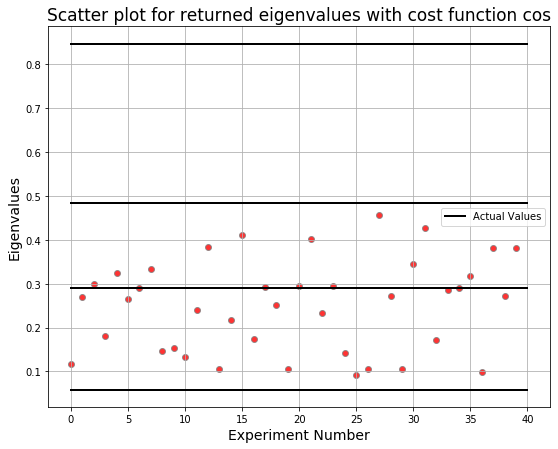

In [41]:
generate_plot1(eig_v, eigen_vals_ret1, 40, "cos")

## Cost function 2 - $cos^{2}(x)$

In [42]:
spea1 = global_max_SPEA(unit, resolution=30, max_metric_val=0.92,cost_function='cos2', max_iters=15)
simulator = Aer.get_backend('qasm_simulator')

In [43]:
eigen_vals_ret1 = []
while len(eigen_vals_ret1) != 40:
    res = spea1.get_eigen_pair(
        backend=simulator, algo='alternate')
    if res['metric'] < 0.8:
        continue
#     print("Result :", res)
    eigen_vals_ret1.append(res['theta'])

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algor

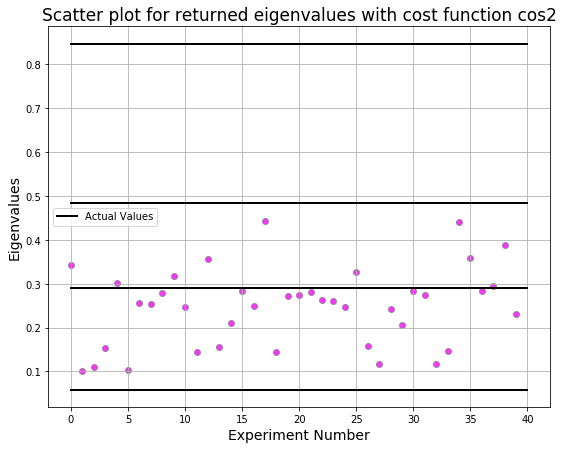

In [44]:
generate_plot1(eig_v, eigen_vals_ret1, 40, "cos2")

## Cost function 3 - $e^{-x}$

In [45]:
spea1 = global_max_SPEA(unit, resolution=30, max_metric_val=0.92,cost_function='exp', max_iters=15)
simulator = Aer.get_backend('qasm_simulator')

In [ ]:
eigen_vals_ret1 = []
while len(eigen_vals_ret1) != 40:
    res = spea1.get_eigen_pair(
        backend=simulator, algo='alternate')
    if res['metric'] < 0.8:
        continue
#     print("Result :", res)
    eigen_vals_ret1.append(res['theta'])

In [ ]:
generate_plot1(eig_v, eigen_vals_ret1, 40, "exp")

## Cost function 4 - $e^{-x^{2}}$

In [47]:
spea1 = global_max_SPEA(unit, resolution=30, max_metric_val=0.92,cost_function='exp2', max_iters=15)
simulator = Aer.get_backend('qasm_simulator')

In [ ]:
eigen_vals_ret1 = []
while len(eigen_vals_ret1) != 40:
    res = spea1.get_eigen_pair(
        backend=simulator, algo='alternate')
    if res['metric'] < 0.8:
        continue
    print("Result :", res)
    eigen_vals_ret1.append(res['theta'])

In [ ]:
generate_plot1(eig_v, eigen_vals_ret1, 40, "exp2")

## Cost function 5 - $\frac{1}{x}$

In [48]:
spea1 = global_max_SPEA(unit, resolution=30, max_metric_val=4,cost_function='inv', max_iters=15)
simulator = Aer.get_backend('qasm_simulator')

In [49]:
eigen_vals_ret1 = []
while len(eigen_vals_ret1) != 40:
    res = spea1.get_eigen_pair(
        backend=simulator, algo='alternate')
    if res['metric'] < 3:
        continue
    print("Result :", res)
    eigen_vals_ret1.append(res['theta'])

Result : {'cost': 0.79296875, 'theta': 0.15249702734839476, 'state': array([-0.48713826+0.00230233j, -0.18936399-0.25082018j,
       -0.45972879-0.31083498j,  0.43501432+0.40830763j]), 'metric': 5.199896442495127}
Result : {'cost': 0.732421875, 'theta': 0.15249702734839476, 'state': array([-0.3976821 -0.39080319j, -0.09766017-0.17480676j,
        0.07528998+0.03132752j,  0.65743043+0.45843444j]), 'metric': 4.802860014619883}
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.88671875, 'theta': 0.10166468489892985, 'state': array([-0.51611297+0.46758139j, -0.33083028-0.41479772j,
       -0.17462422-0.24796138j,  0.23212314+0.29602298j]), 'metric': 8.721993786549707}
Result : {'cost': 0.810546875, 'theta': 0.16379310344827586, 'state': array([-0.25536801-0.40708924j,  0.21260383-0.72729819j,
        0.2747

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.80078125, 'theta': 0.15755053507728892, 'state': array([ 0.1791039 -0.23108478j,  0.40639508-0.4858092j ,
        0.05238658+0.32562074j, -0.04400372+0.63454277j]), 'metric': 5.082694575471699}
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.82421875, 'theta': 0.10344827586206896, 'state': array([-0.61713723+0.08263495j,  0.12603372-0.67740293j,
        0.27059781-0.19390045j, -0.03701693+0.15925785j]), 'metric': 7.967447916666667}
Result : {'cost': 0.744140625, 'theta': 0.1810344827586207, 'state': array([-0.32726092-0.38212718j, -0.34059668-0.12658813j,
       -0.19555665-0.36119188j,  0.23847375+0.62392046j]), 'metric': 4.110491071428571}
Result : {'cost': 0.6953125, 'theta': 0.12604042806183113, 'state': array([ 0.01557343+0.22066904j,  0.4069139 +0.50812873j,
        0.4045973

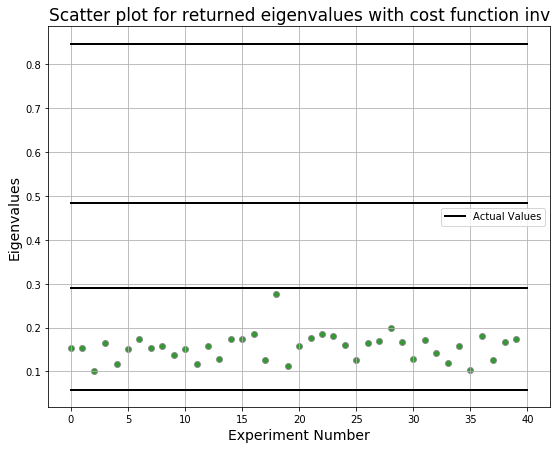

In [50]:
generate_plot1(eig_v, eigen_vals_ret1, 40, "inv")

## Cost function 6 - $\frac{1}{x^{2}}$

In [56]:
spea1 = global_max_SPEA(unit, resolution=30, max_metric_val=20,cost_function='inv2', max_iters=15)
simulator = Aer.get_backend('qasm_simulator')

In [57]:
eigen_vals_ret1 = []
while len(eigen_vals_ret1) != 40:
    res = spea1.get_eigen_pair(
        backend=simulator, algo='alternate')
    if res['metric'] < 15:
        continue
    print("Result :", res)
    eigen_vals_ret1.append(res['theta'])

Result : {'cost': 0.744140625, 'theta': 0.17207936979785968, 'state': array([-0.12659561+0.55990361j, -0.62847647-0.33874749j,
        0.27056807+0.13547615j, -0.05879569-0.25638089j]), 'metric': 25.130284249941052}
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.66015625, 'theta': 0.1552467300832342, 'state': array([-0.06737219+0.05163415j,  0.35289821-0.54302408j,
        0.19639961+0.06937067j, -0.45898369+0.56509423j]), 'metric': 27.39061706204124}
Result : {'cost': 0.8046875, 'theta': 0.17330558858501782, 'state': array([-0.3621236 +0.36825962j, -0.76915506+0.04393548j,
       -0.02576316-0.3457365j , -0.02995655-0.13647951j]), 'metric': 26.791814018694343}
Result : {'cost': 0.81640625, 'theta': 0.15249702734839476, 'state': array([ 0.57175098+0.17020984j,  0.22318566+0.43572304j,
       -0.19757553-0.31123736j, -0.17067978-0.48931242j]), 'metric': 35.106179156739586}
Result : {'cost': 0.77734375, 'theta': 0.1724137931034483, 'state': ar

Result : {'cost': 0.775390625, 'theta': 0.16379310344827586, 'state': array([-0.07966491+0.02284393j, -0.67678166+0.33586339j,
        0.28382136-0.16334116j, -0.08044227-0.55550712j]), 'metric': 28.90209487534626}
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.66796875, 'theta': 0.15755053507728892, 'state': array([ 0.14296082-0.58661013j,  0.08470857+0.67989241j,
       -0.04032079+0.2697094j , -0.2981359 -0.05260783j]), 'metric': 26.910166206835182}
Result : {'cost': 0.771484375, 'theta': 0.16379310344827588, 'state': array([-0.31025381+0.51595173j, -0.08923165+0.6435821j ,
       -0.04249058-0.28252051j,  0.05463736-0.3616181j ]), 'metric': 28.75649238227146}
Maximum iterations reached for the estimation.
Terminating algorithm...
Result : {'cost': 0.751953125, 'theta': 0.18326397146254453, 'state': array([ 0.44600707+0.22735698j,  0.02792753+0.0457269j ,
        0.26904184+0.15449503j, -0.60582433-0.53220321j]), 'metric': 22.389097155211

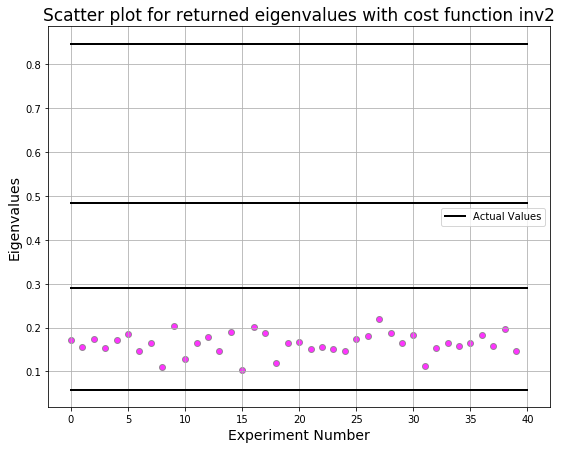

In [59]:
generate_plot1(eig_v, eigen_vals_ret1, 40, "inv2")